# Frequency Analysis for South Florida (April - June)

NB: This ipynb complements our blog post published in our [website](https://covid.dh.miami.edu/2020/08/15/frequency-analysis-for-south-florida-april-june/)

In order to run this script correctly, run every one of the steps once at a time and wait that the * symbol has turned into a number.

__Authors:__

* Susanna Allés Torrent, [susanna_alles@miami.edu](mailto:susanna_alles@miami.edu), University of Miami
* Dieyun Song, [dxs1138@miami.edu](mailto:dxs1138@miami.edu), University of Miami 
* Jerry Bonnell, [j.bonnell@miami.edu](mailto:j.bonnell@miami.edu), University of Miami



## Setting up

Setting up by installing and importing libraries needed (contained in the `requirements.txt` file)

In [1]:
!pip3 install -r requirements.txt  # may need to replace "pip3" with "conda"

You should consider upgrading via the '/home/jbonnell/.pyenv/versions/3.8.3/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
from coveet import count_ngrams, uniq_vocab_by_group
from collections import Counter
from pprint import pprint
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None

## Top 30 words in South Florida from April 25th to May 25th: English vs Spanish

[3] Query of tweets through our API:

In [3]:
!python3 coveet.py query -g fl -l en es -d 2020-04-25 2020-05-25 

Namespace(all=False, date=[datetime.datetime(2020, 4, 25, 0, 0), datetime.datetime(2020, 5, 25, 0, 0)], func=<function handle_query at 0x7fe752f63550>, geo=['fl'], lang=['en', 'es'], search=None)
wrote df to dhcovid_2020-4-25_2020-5-25_en_es_fl.csv 🎉


[4] Coveet.py, with `pandas` package, processes the csv file (`dhcovid_2020-4-25_2020-5-25_en_es_fl.csv`) through the function `df` which stands for dataframe (spreadsheet): 

In [183]:
df = pd.read_csv('dhcovid_2020-4-25_2020-5-25_en_es_fl.csv', index_col=0)

[5] Tidy the file by removing stopwords:

In [184]:
!python3 coveet.py tidy -file dhcovid_2020-4-25_2020-5-25_en_es_fl.csv -stopwords ../stopwords/stopwords_en.txt ../stopwords/stopwords_es.txt ../stopwords/stopwords_hashtags.txt

Namespace(file='dhcovid_2020-4-25_2020-5-25_en_es_fl.csv', func=<function handle_tidy at 0x7fd697871670>, lemmatize=False, search=None, stopwords=['../stopwords/stopwords_en.txt', '../stopwords/stopwords_es.txt', '../stopwords/stopwords_hashtags.txt'])
wrote tidied df to dhcovid_2020-4-25_2020-5-25_en_es_fl_stopworded.csv 🎉


In [185]:
df = pd.read_csv('dhcovid_2020-4-25_2020-5-25_en_es_fl_stopworded.csv', index_col=0) # run from here using this file

[6] Organize dataframe to show date, text, and hashtags. "str.split" separates strings of texts into individual words.

In [186]:
df['date'] = pd.to_datetime(df['date'])
df['text'] = df['text'].str.split()
df['hashtags'] = df['hashtags'].str.split()

[7] Visualize results in top ngrams:

In [187]:
top_n = 30  # top 30 words
n_gram = 1  # ask for word frequency (i.e. an n-gram where n=1)

In [188]:
col_name = 'text'  # set to either 'text' or 'hashtags'

In [189]:
df = df.dropna(subset=[col_name])

In [190]:
# counts is of the form: location, language, actual tuples
# count_ngrams returns a (default) dictionary of word tuples (ngrams) 
# with its associated frequency; we then use Counter from python collections 
# to tell us the top n most popular ones 
counts = {(g, l): Counter(count_ngrams(t, n_gram, consecutive=False)).most_common(top_n)
          for (g, l), t in df.groupby(["geo", "lang"])[col_name]}

This are the exact counts for each word... 

In [191]:
pprint(counts)

{('fl', 'en'): [(('pandemic',), 1548),
                (('people',), 1202),
                (('coronavirus',), 1180),
                (('florida',), 1035),
                (('help',), 913),
                (('trump',), 880),
                (('cases',), 868),
                (('health',), 837),
                (('like',), 752),
                (('time',), 742),
                (('deaths',), 700),
                (('home',), 682),
                (('crisis',), 671),
                (('testing',), 648),
                (('today',), 616),
                (('need',), 615),
                (('video',), 604),
                (('patients',), 601),
                (('dont',), 552),
                (('miami',), 550),
                (('day',), 538),
                (('news',), 533),
                (('business',), 531),
                (('impact',), 528),
                (('world',), 524),
                (('work',), 522),
                (('im',), 514),
                (('positive',), 504),
  

Produce bar charts with `matplotlib`.

In [192]:
from pylab import rcParams
rcParams['figure.figsize'] = 40, 40  # setting figure size
plt.rcParams.update({'font.size': 22})  # setting font size

In [193]:
def plot_bar_matrix(counts, num_top_words, num_cols=2, 
                    super_title="figure title", super_font=50):
    """
    function for plotting a matrix of bar plots 
    
    counts: a dictionary mapping from a geo-lang pair identifier (generalizable to any identifier)
            to a list of (word, count) tuples containing the top word frequencies
    num_cols: desired number of columns to show in the grid
    str_func: function for "pretty printing" the title used in each of the bar charts  
    """
    # automatically determine the grid to use based on desired number of columns 
    num_rows = len(counts.keys()) // num_cols
    num_rows += 1 if num_rows * num_cols < len(counts.keys()) else 0
    fig, axes = plt.subplots(num_rows, num_cols)
    flattened = axes.flatten()
    for i, (id_pair, counts) in enumerate(counts.items()):
        labels = [" ".join(w) for w, _ in counts]
        y = [n for _, n in counts]
        cmap = plt.get_cmap('spring')
        colors = plt.get_cmap('spring')(np.linspace(0, 1, len(labels)))
        flattened[i].set_title(f"{' '.join([str(p) for p in id_pair])}")
        flattened[i].barh(y=range(0, num_top_words), width=y, color=colors, tick_label=labels) # range should equal to the # of top words you want to retrieve.
        flattened[i].invert_yaxis()  # reverse the visualization order along the y-axis
    fig.suptitle(super_title, fontsize=50)

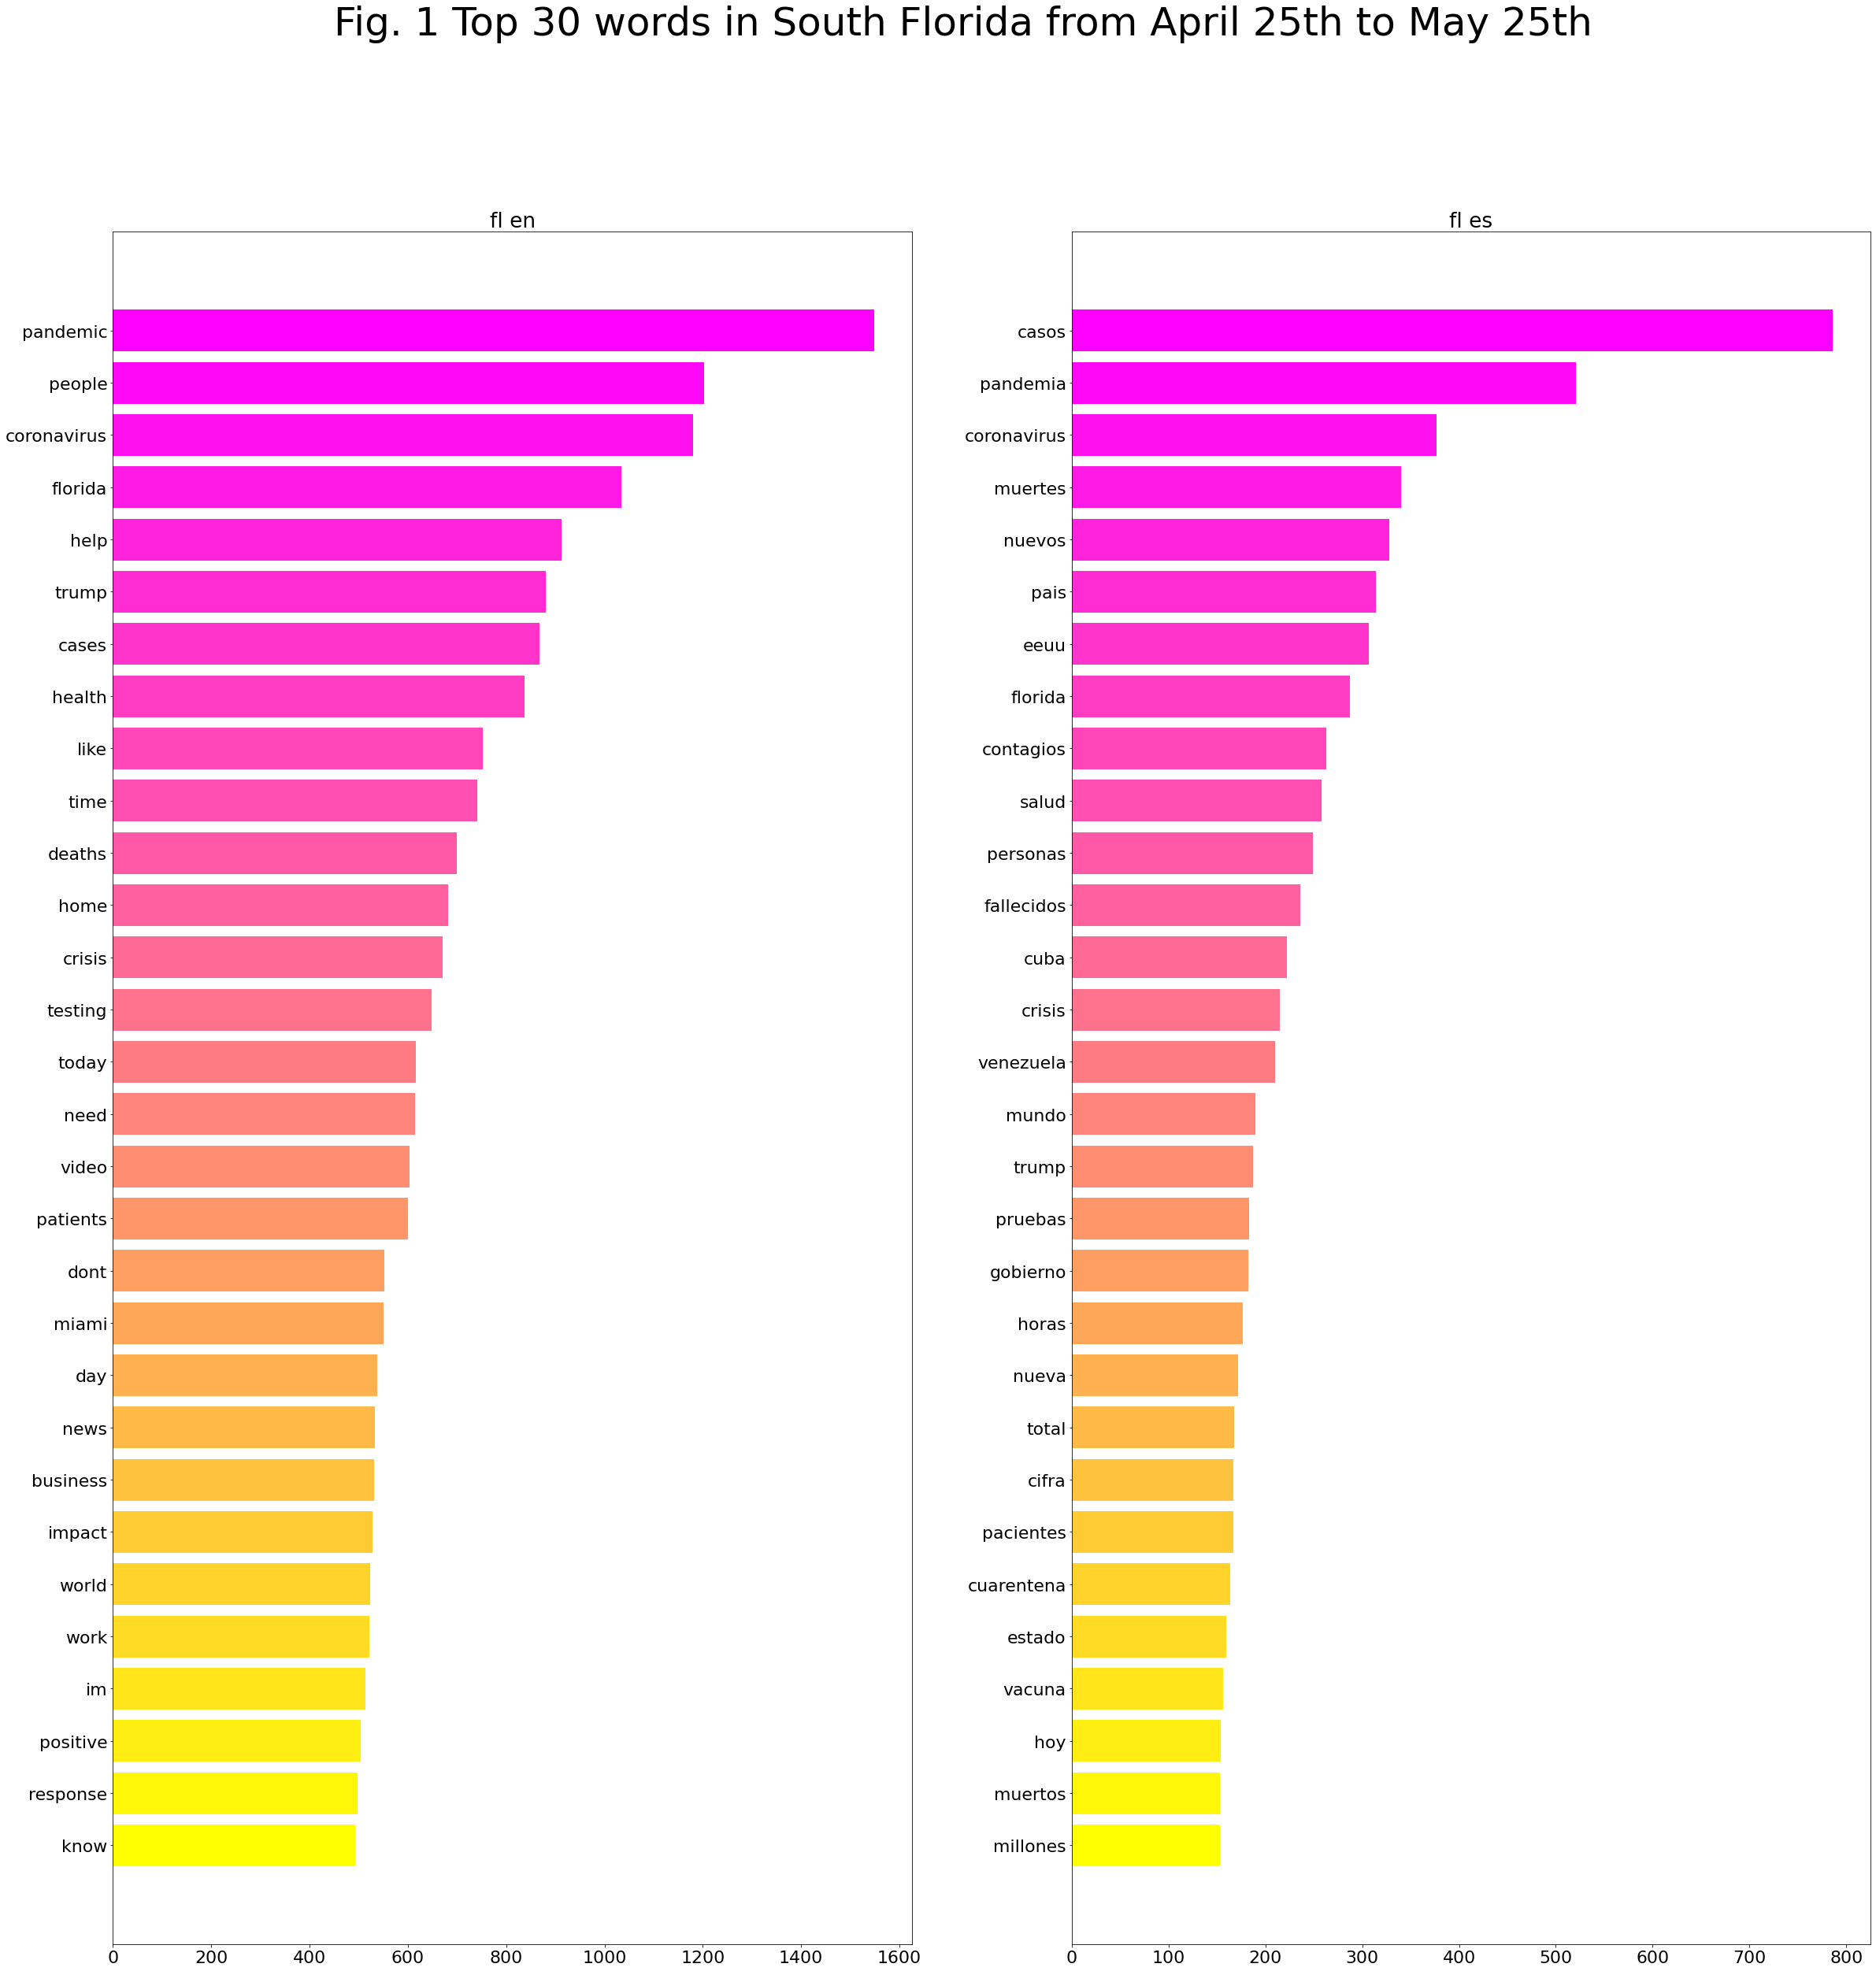

In [194]:
plot_bar_matrix(counts, num_top_words = top_n, num_cols = 2, 
               super_title = 'Fig. 1 Top 30 words in South Florida from April 25th to May 25th', super_font = 50)

## Top 20 hashtags South Florida from April 25th to May 25th: English vs Spanish

This is the same proces but recovering the 20 most used hashtags by language in South Florida. 

In [195]:
top_n = 30  # top 30 words
n_gram = 1  # ask for word frequency (i.e. an n-gram where n=1)
col_name = 'hashtags'  # set to either 'text' or 'hashtags'
df_text = df.dropna(subset=[col_name])
counts = {(g, l): Counter(count_ngrams(t, n_gram, consecutive=False)).most_common(top_n)
          for (g, l), t in df_text.groupby(["geo", "lang"])[col_name]}

In [196]:
pprint(counts)

{('fl', 'en'): [(('#health',), 278),
                (('#acscovid19',), 185),
                (('#miami',), 149),
                (('#givingtuesdaynow',), 146),
                (('#pandemic',), 128),
                (('#news',), 118),
                (('#florida',), 115),
                (('#breaking',), 114),
                (('#stayhome',), 95),
                (('#360wisemedia',), 92),
                (('#quarantine',), 86),
                (('#',), 84),
                (('#staysafe',), 77),
                (('#healthcare',), 77),
                (('#socialdistancing',), 73),
                (('#maritime',), 59),
                (('#marketing',), 58),
                (('#corona',), 57),
                (('#cdc',), 57),
                (('#fortlauderdale',), 54),
                (('#realestate',), 54),
                (('#ai',), 50),
                (('#business',), 48),
                (('#trumpvirus',), 47),
                (('#hr',), 46),
                (('#mask',), 42),
        

In [197]:
from pylab import rcParams
rcParams['figure.figsize'] = 40, 40  # setting figure size
plt.rcParams.update({'font.size': 22})  # setting font size

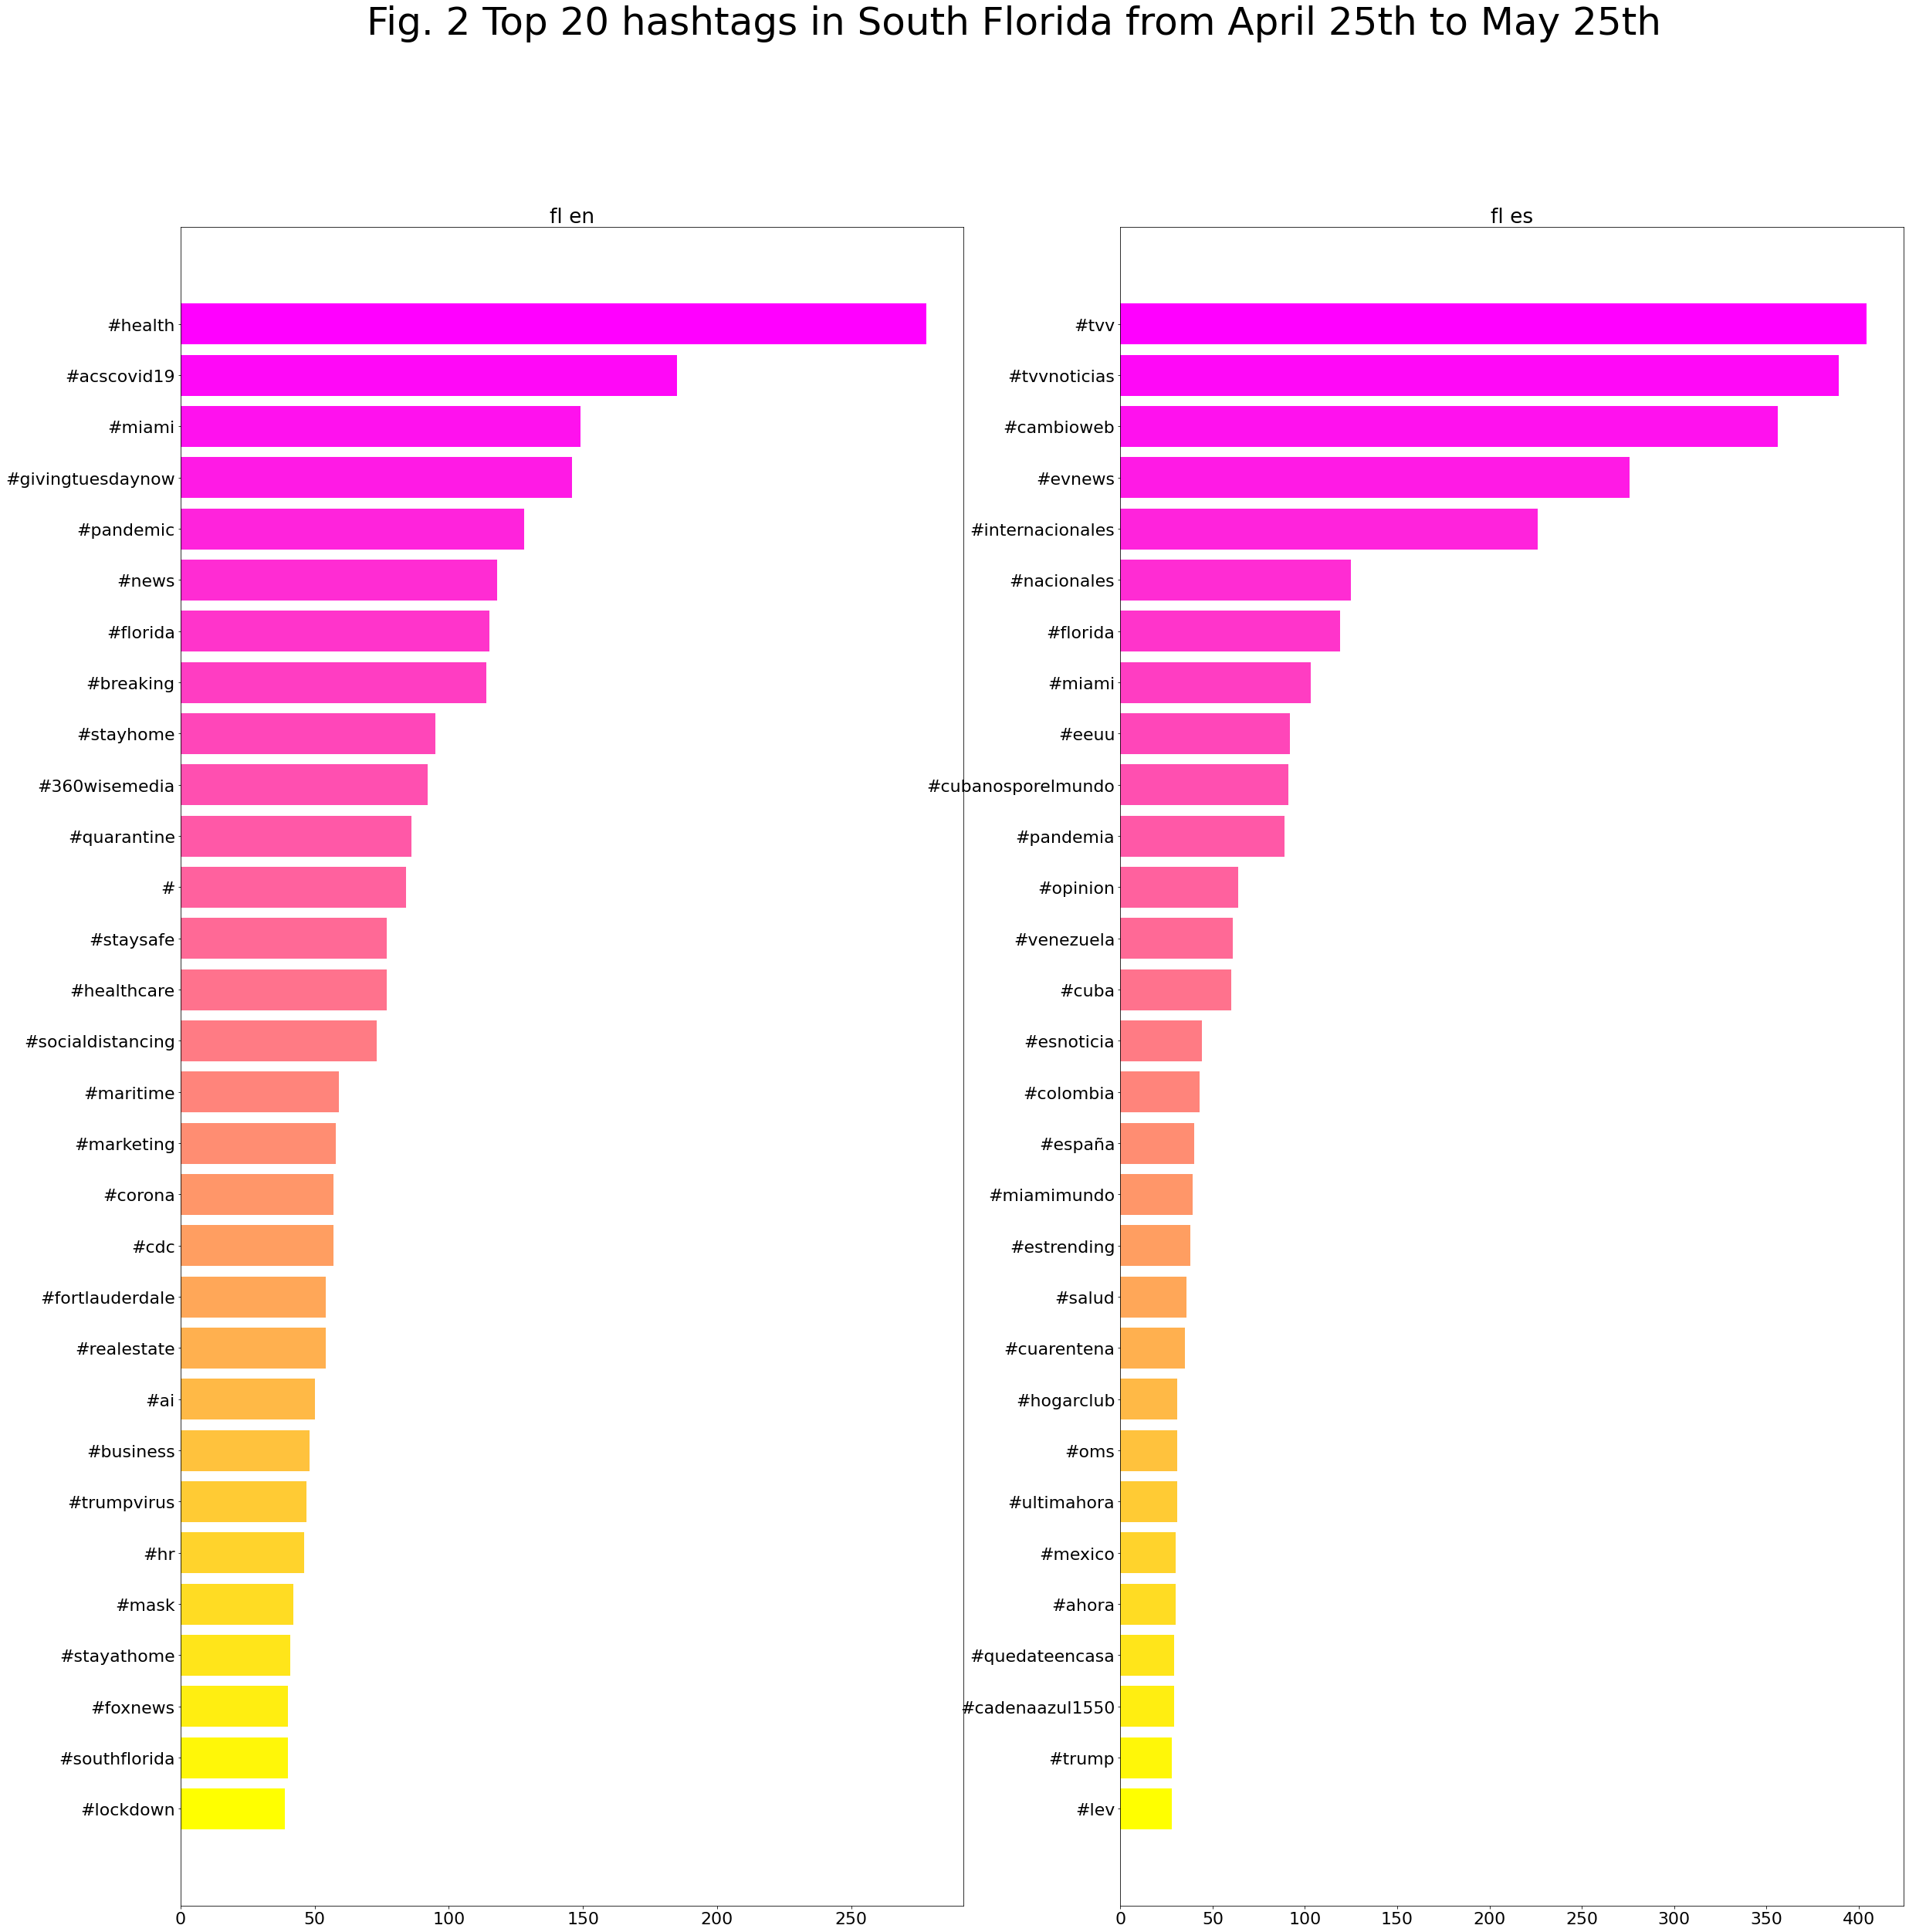

In [198]:
plot_bar_matrix(counts, num_top_words = top_n, num_cols = 2,
               super_title = 'Fig. 2 Top 20 hashtags in South Florida from April 25th to May 25th', super_font = 50)

### Top unique hastags 

In [199]:
col_name = "hashtags"

In [200]:
df = df.dropna(subset=[col_name])

In [201]:
grouping = df.groupby(["geo", "lang"])[col_name]
vocab_dic = uniq_vocab_by_group(grouping)  # unique vocab dictionary 
df[col_name] = df.apply(lambda x : set(x[col_name]) & vocab_dic[(x['geo'], x['lang'])],
                        result_type='reduce', axis=1)  # filtering tweets by that dic

In [202]:
counts = {k: Counter(count_ngrams(t, n_gram, consecutive=False)).most_common(top_n) for k, t in grouping}

In [203]:
pprint(counts)

{('fl', 'en'): [(('#health',), 278),
                (('#acscovid19',), 185),
                (('#givingtuesdaynow',), 146),
                (('#news',), 118),
                (('#360wisemedia',), 92),
                (('#maritime',), 59),
                (('#fortlauderdale',), 54),
                (('#business',), 48),
                (('#trumpvirus',), 47),
                (('#hr',), 46),
                (('#foxnews',), 40),
                (('#southflorida',), 40),
                (('#crypto',), 37),
                (('#weddingplanner',), 37),
                (('#wedding',), 37),
                (('#fitness',), 33),
                (('#bride',), 33),
                (('#globalcoin',), 31),
                (('#makingwaves',), 31),
                (('#freightindustrynews',), 31),
                (('#employees',), 29),
                (('#learnmore',), 29),
                (('#economy',), 28),
                (('#digitalmarketing',), 27),
                (('#smartnews',), 26),
        

In [204]:
from pylab import rcParams
rcParams['figure.figsize'] = 40, 40  # setting figure size
plt.rcParams.update({'font.size': 22})  # setting font size

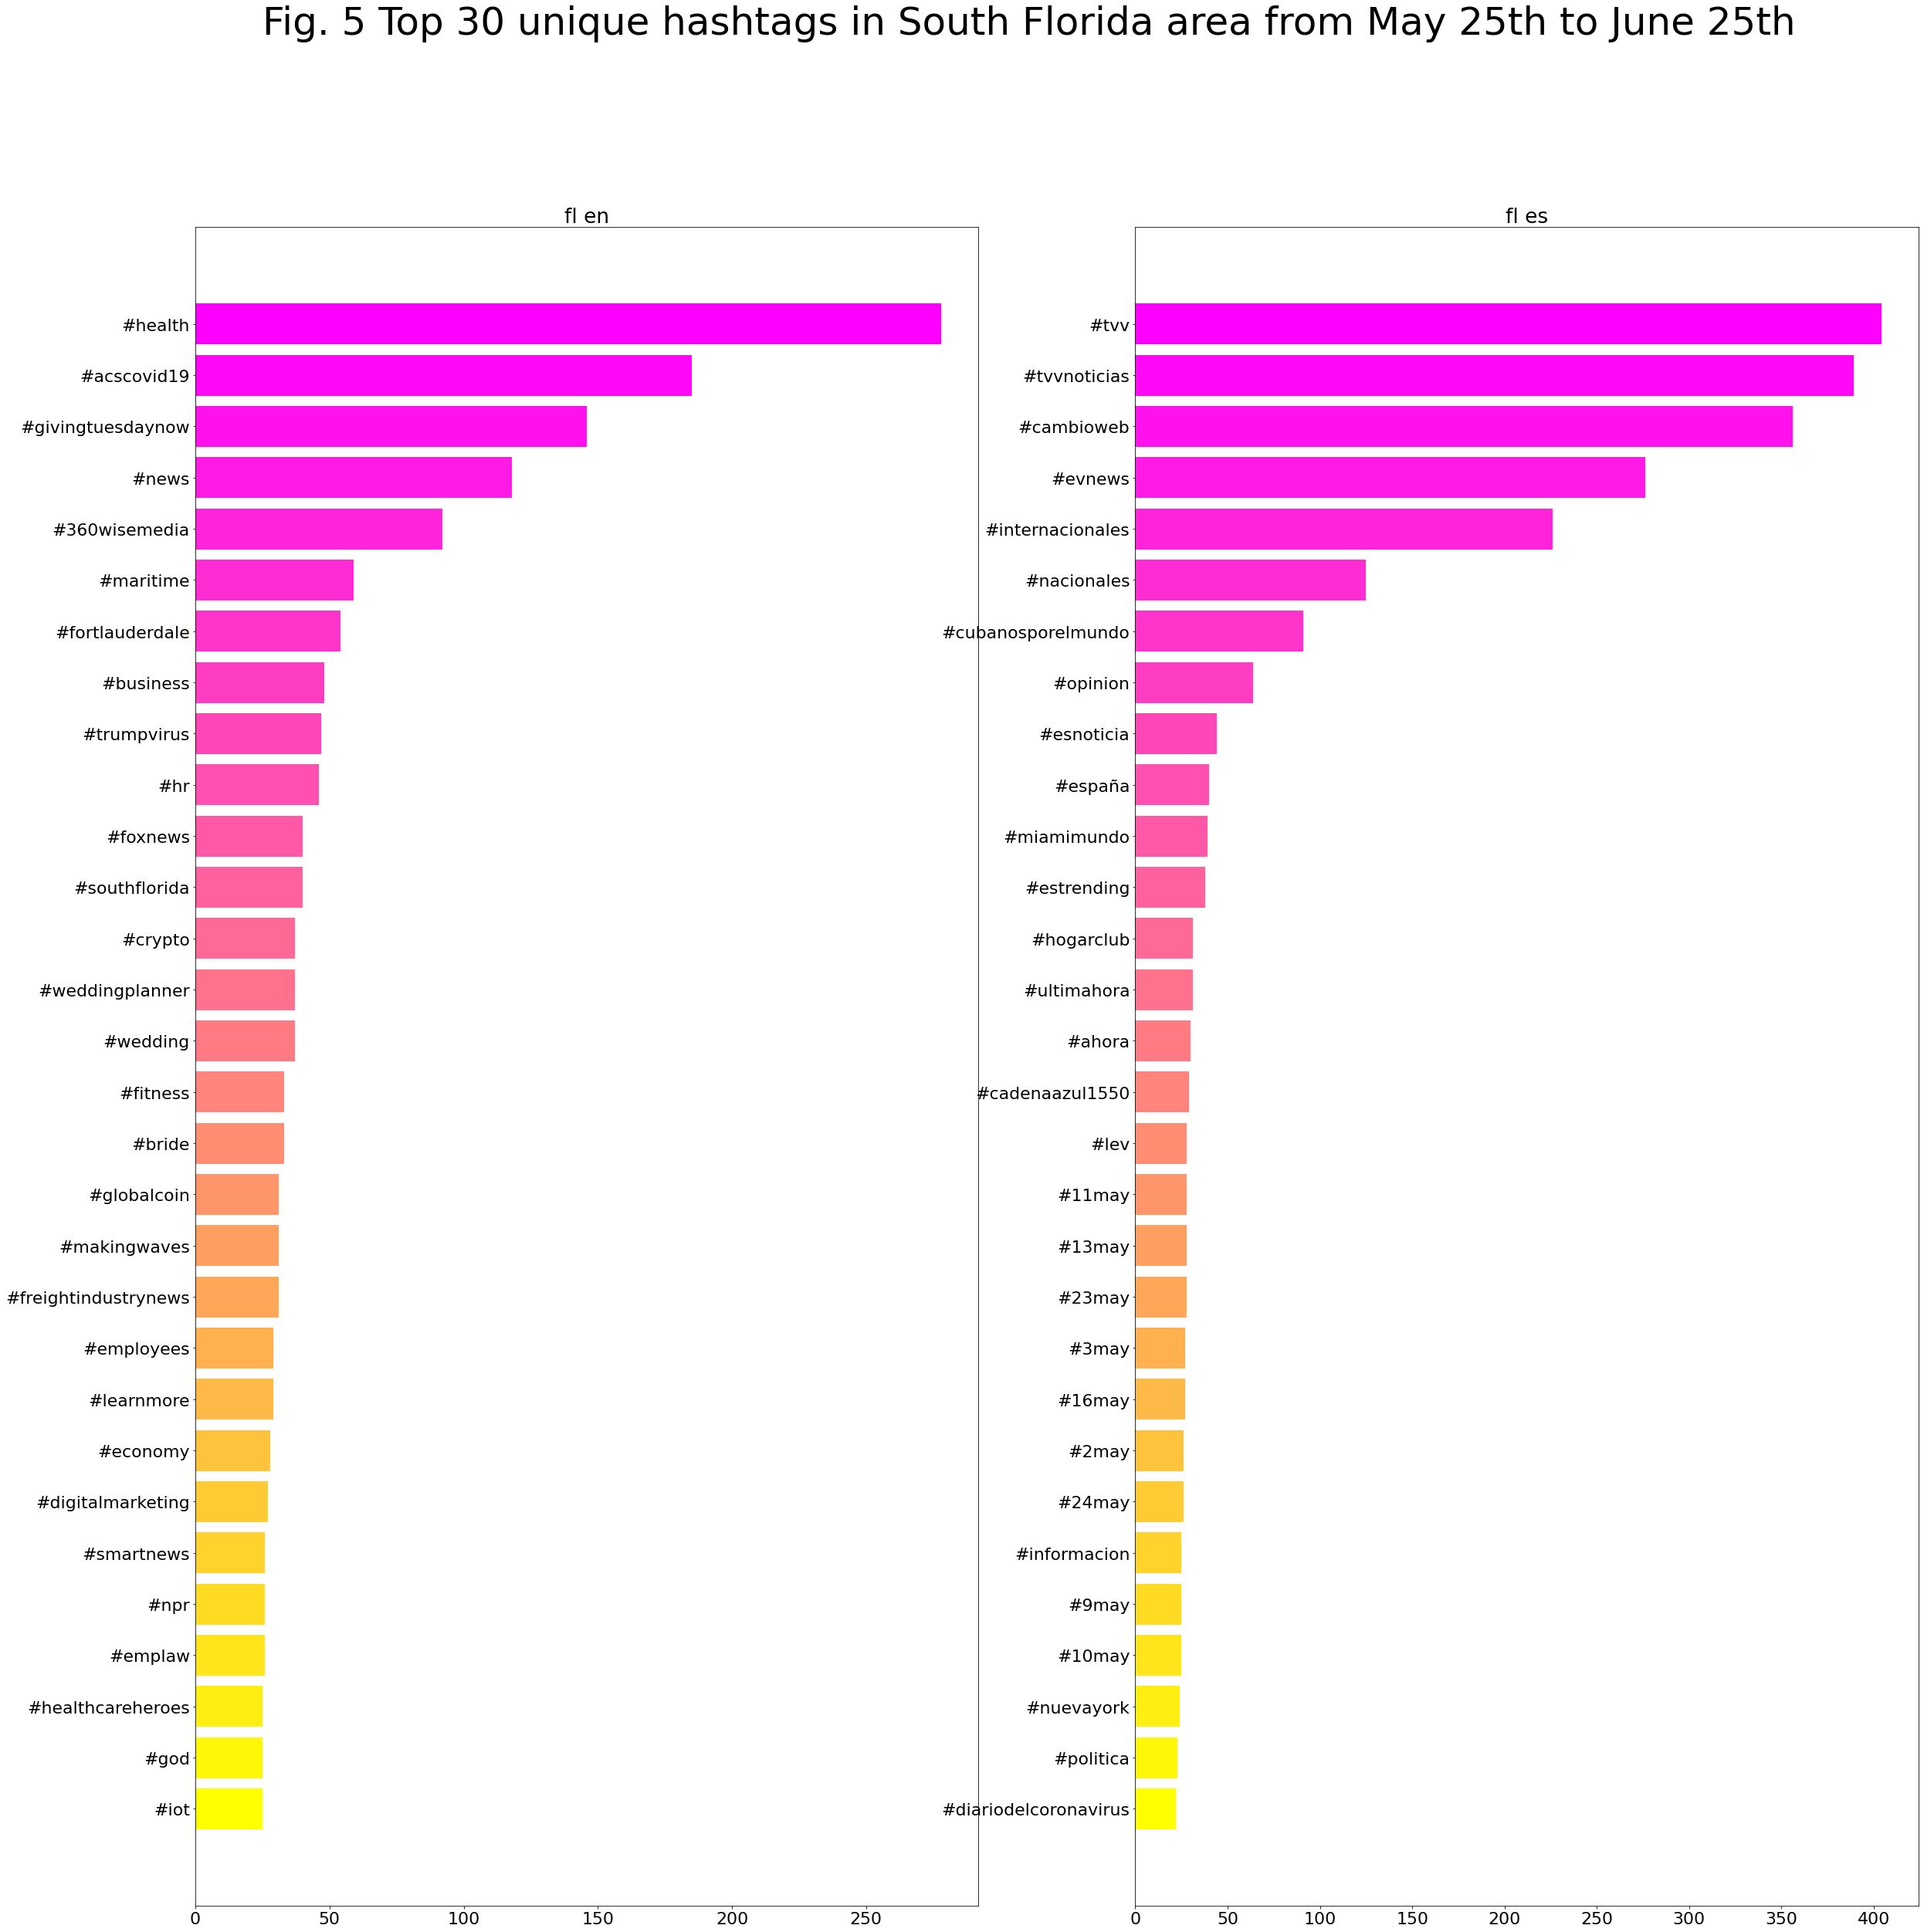

In [206]:
plot_bar_matrix(counts, num_top_words = top_n, num_cols = 2,
               super_title = 'Fig. 5 Top 30 unique hashtags in South Florida area from May 25th to June 25th', super_font = 50)

## Top 30 words in South Florida from May 25th to June 25th: English vs Spanish

In [85]:
!python3 coveet.py query -g fl -l en es -d 2020-05-25 2020-06-25

Namespace(all=False, date=[datetime.datetime(2020, 5, 25, 0, 0), datetime.datetime(2020, 6, 25, 0, 0)], func=<function handle_query at 0x7f4c9d331550>, geo=['fl'], lang=['en', 'es'], search=None)
wrote df to dhcovid_2020-5-25_2020-6-25_en_es_fl.csv 🎉


In [207]:
df = pd.read_csv('dhcovid_2020-5-25_2020-6-25_en_es_fl.csv', index_col=0)

In [208]:
!python3 coveet.py tidy -file dhcovid_2020-5-25_2020-6-25_en_es_fl.csv -stopwords ../stopwords/stopwords_es.txt ../stopwords/stopwords_en.txt ../stopwords/stopwords_hashtags.txt

Namespace(file='dhcovid_2020-5-25_2020-6-25_en_es_fl.csv', func=<function handle_tidy at 0x7fc9f1e56670>, lemmatize=False, search=None, stopwords=['../stopwords/stopwords_es.txt', '../stopwords/stopwords_en.txt', '../stopwords/stopwords_hashtags.txt'])
wrote tidied df to dhcovid_2020-5-25_2020-6-25_en_es_fl_stopworded.csv 🎉


In [209]:
df = pd.read_csv('dhcovid_2020-5-25_2020-6-25_en_es_fl_stopworded.csv', index_col=0) # run from here using this file

In [210]:
df['date'] = pd.to_datetime(df['date'])
df['text'] = df['text'].str.split()
df['hashtags'] = df['hashtags'].str.split()

In [211]:
top_n = 30  # top 30 words
n_gram = 1  # ask for word frequency (i.e. an n-gram where n=1)
col_name = 'text'  # set to either 'text' or 'hashtags'
df_text = df.dropna(subset=[col_name])
counts = {(g, l): Counter(count_ngrams(t, n_gram, consecutive=False)).most_common(top_n)
          for (g, l), t in df_text.groupby(["geo", "lang"])[col_name]}

In [212]:
pprint(counts)

{('fl', 'en'): [(('cases',), 1260),
                (('pandemic',), 988),
                (('people',), 945),
                (('florida',), 920),
                (('like',), 663),
                (('health',), 544),
                (('coronavirus',), 541),
                (('dont',), 528),
                (('trump',), 499),
                (('time',), 491),
                (('deaths',), 475),
                (('positive',), 452),
                (('going',), 444),
                (('testing',), 435),
                (('miami',), 431),
                (('im',), 429),
                (('help',), 426),
                (('today',), 412),
                (('know',), 393),
                (('covid',), 384),
                (('home',), 378),
                (('need',), 372),
                (('day',), 370),
                (('state',), 360),
                (('numbers',), 358),
                (('business',), 357),
                (('news',), 345),
                (('world',), 334),
        

In [213]:
from pylab import rcParams
rcParams['figure.figsize'] = 40, 40  # setting figure size
plt.rcParams.update({'font.size': 22})  # setting font size

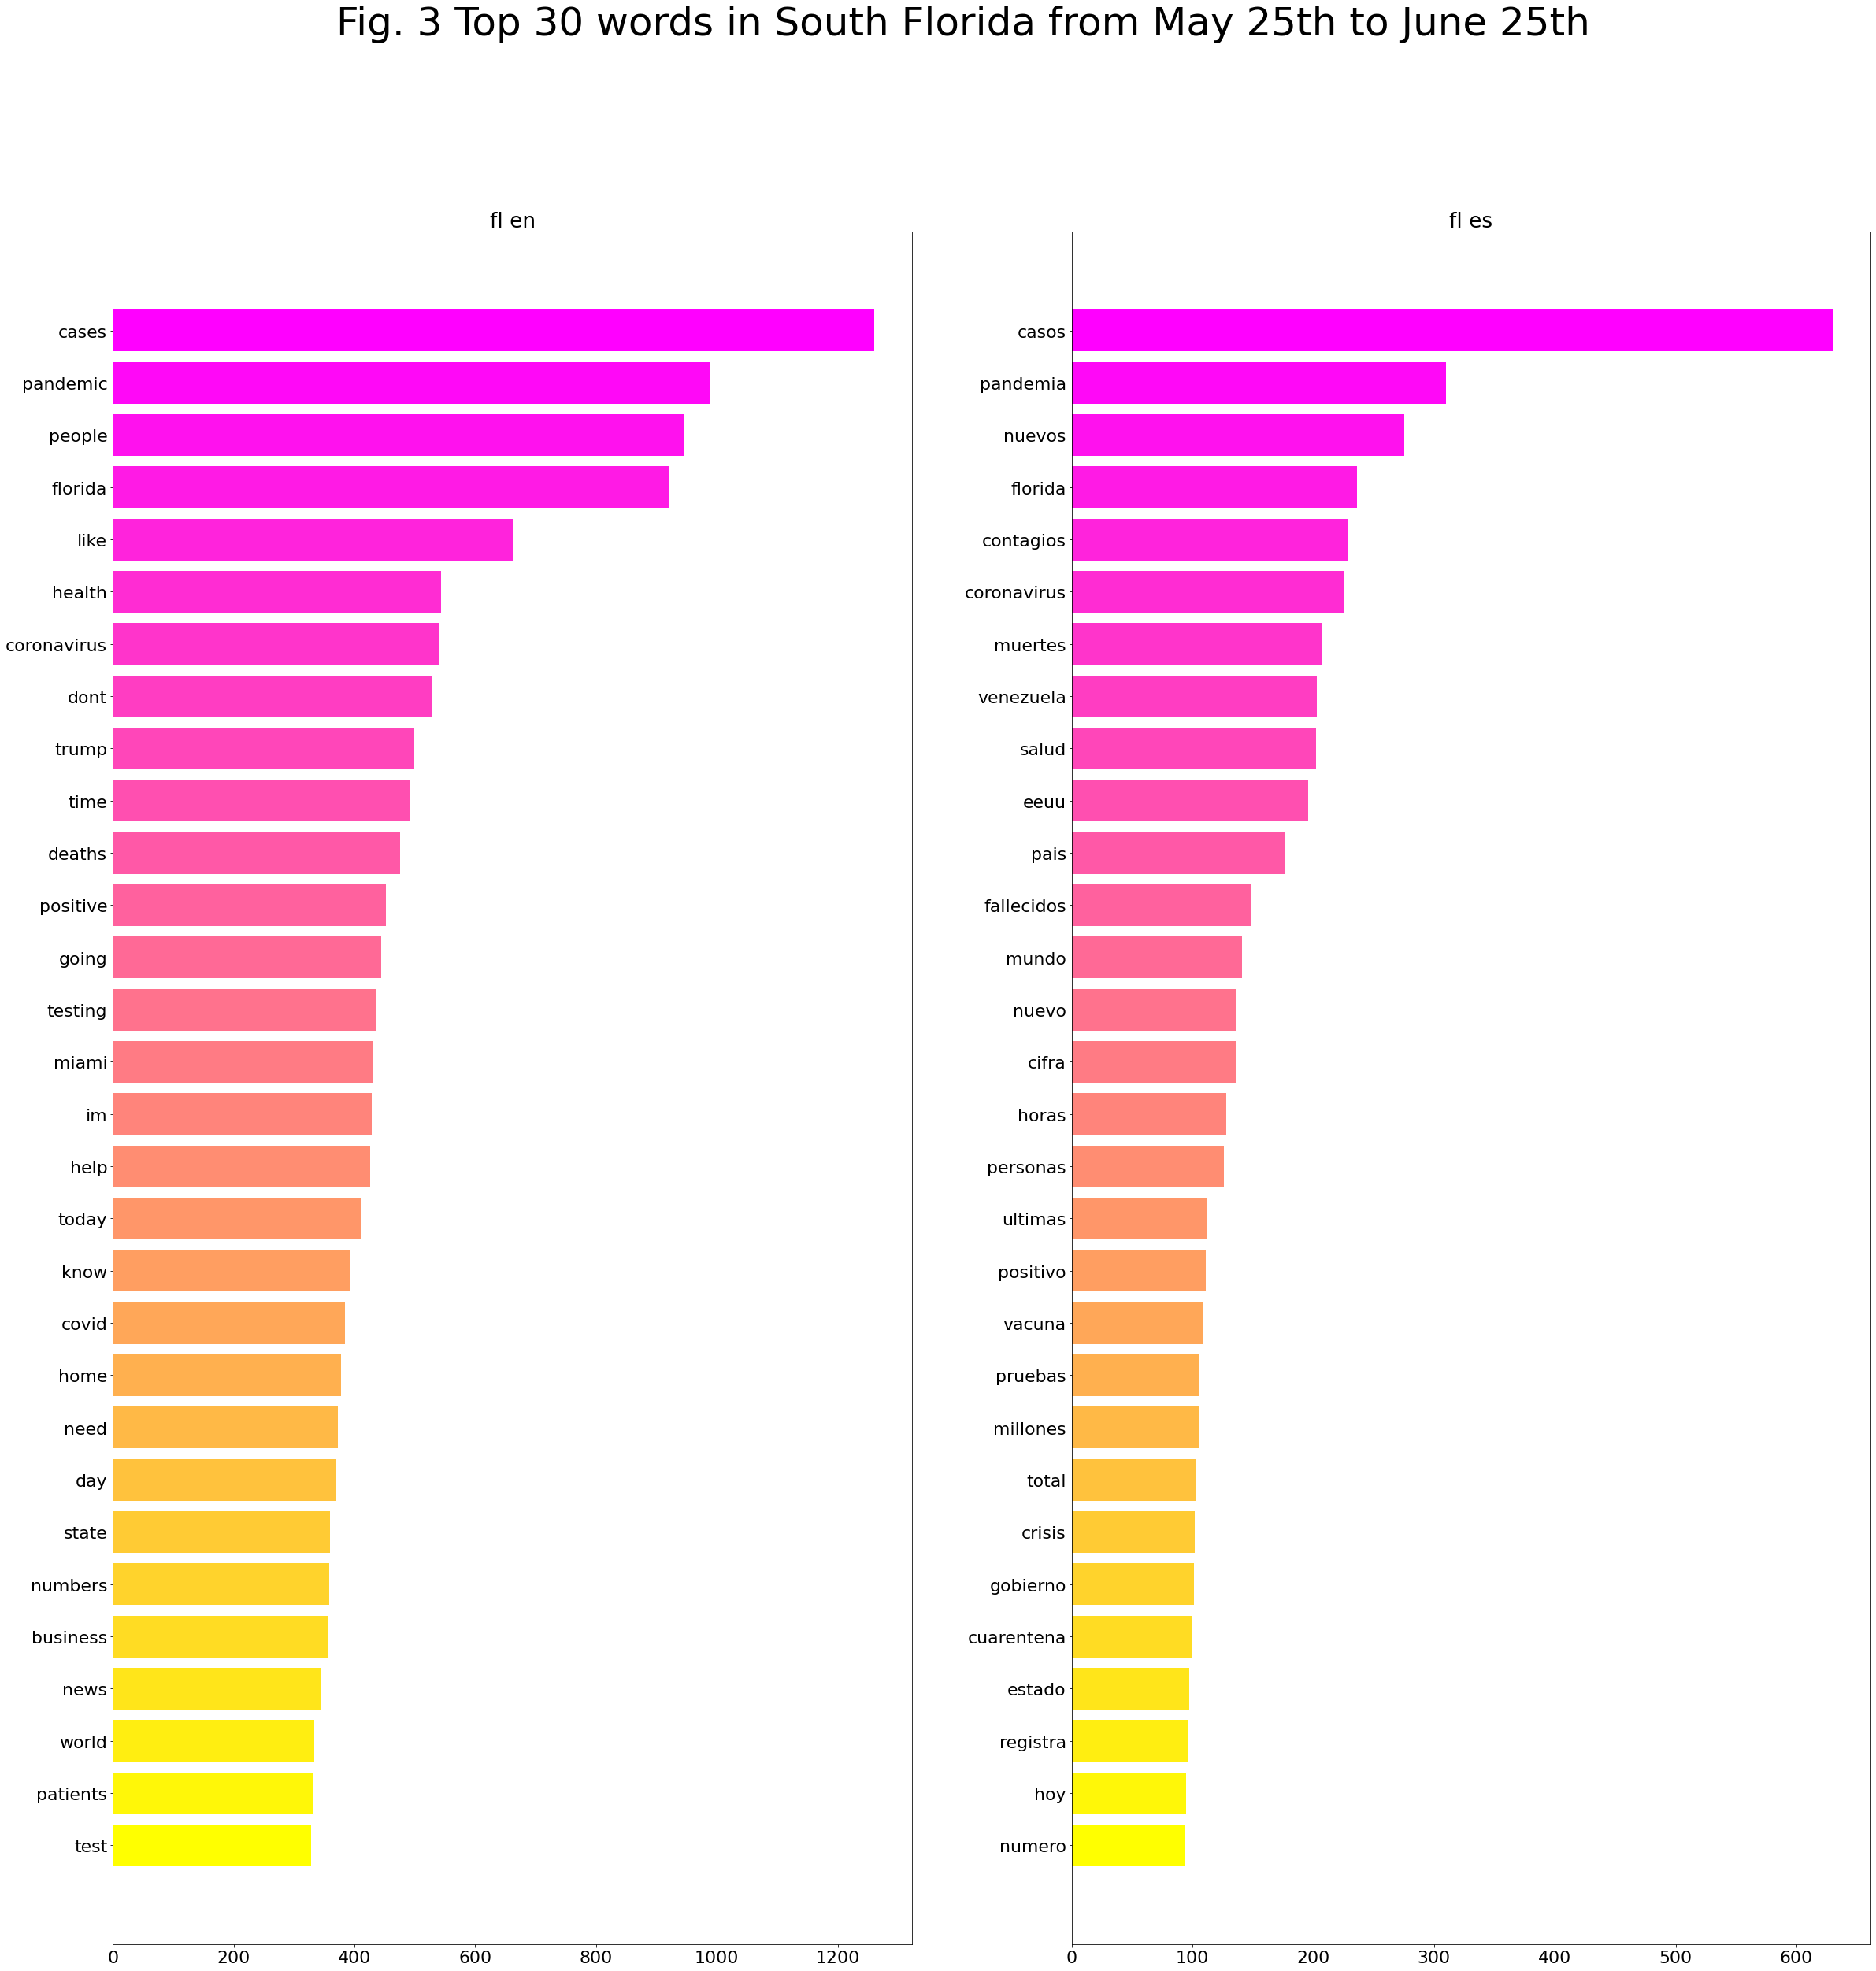

In [215]:
plot_bar_matrix(counts, num_top_words = top_n, num_cols = 2,
               super_title = 'Fig. 3 Top 30 words in South Florida from May 25th to June 25th', super_font = 50)

## Top 20 hashtags South Florida from May 25th to June 25th: English vs Spanish

In [216]:
top_n = 30  # top 30 words
n_gram = 1  # ask for word frequency (i.e. an n-gram where n=1)
col_name = 'hashtags'  # set to either 'text' or 'hashtags'
df_text = df.dropna(subset=[col_name])
counts = {(g, l): Counter(count_ngrams(t, n_gram, consecutive=False)).most_common(top_n)
          for (g, l), t in df_text.groupby(["geo", "lang"])[col_name]}

In [217]:
pprint(counts)

{('fl', 'en'): [(('#health',), 130),
                (('#florida',), 113),
                (('#breaking',), 107),
                (('#miami',), 85),
                (('#news',), 78),
                (('#pandemic',), 71),
                (('#cdc',), 55),
                (('#maritime',), 51),
                (('#blacklivesmatter',), 51),
                (('#hr',), 47),
                (('#newsreport',), 46),
                (('#healthcare',), 45),
                (('#',), 40),
                (('#reopening',), 35),
                (('#ai',), 35),
                (('#zoom',), 34),
                (('#georgefloyd',), 34),
                (('#employees',), 34),
                (('#realestate',), 33),
                (('#northofnyc',), 32),
                (('#emplaw',), 32),
                (('#inspections',), 30),
                (('#virtualopenhouse',), 29),
                (('#smallbusiness',), 28),
                (('#quarantine',), 25),
                (('#business',), 25),
           

In [218]:
from pylab import rcParams
rcParams['figure.figsize'] = 40, 40  # setting figure size
plt.rcParams.update({'font.size': 22})  # setting font size

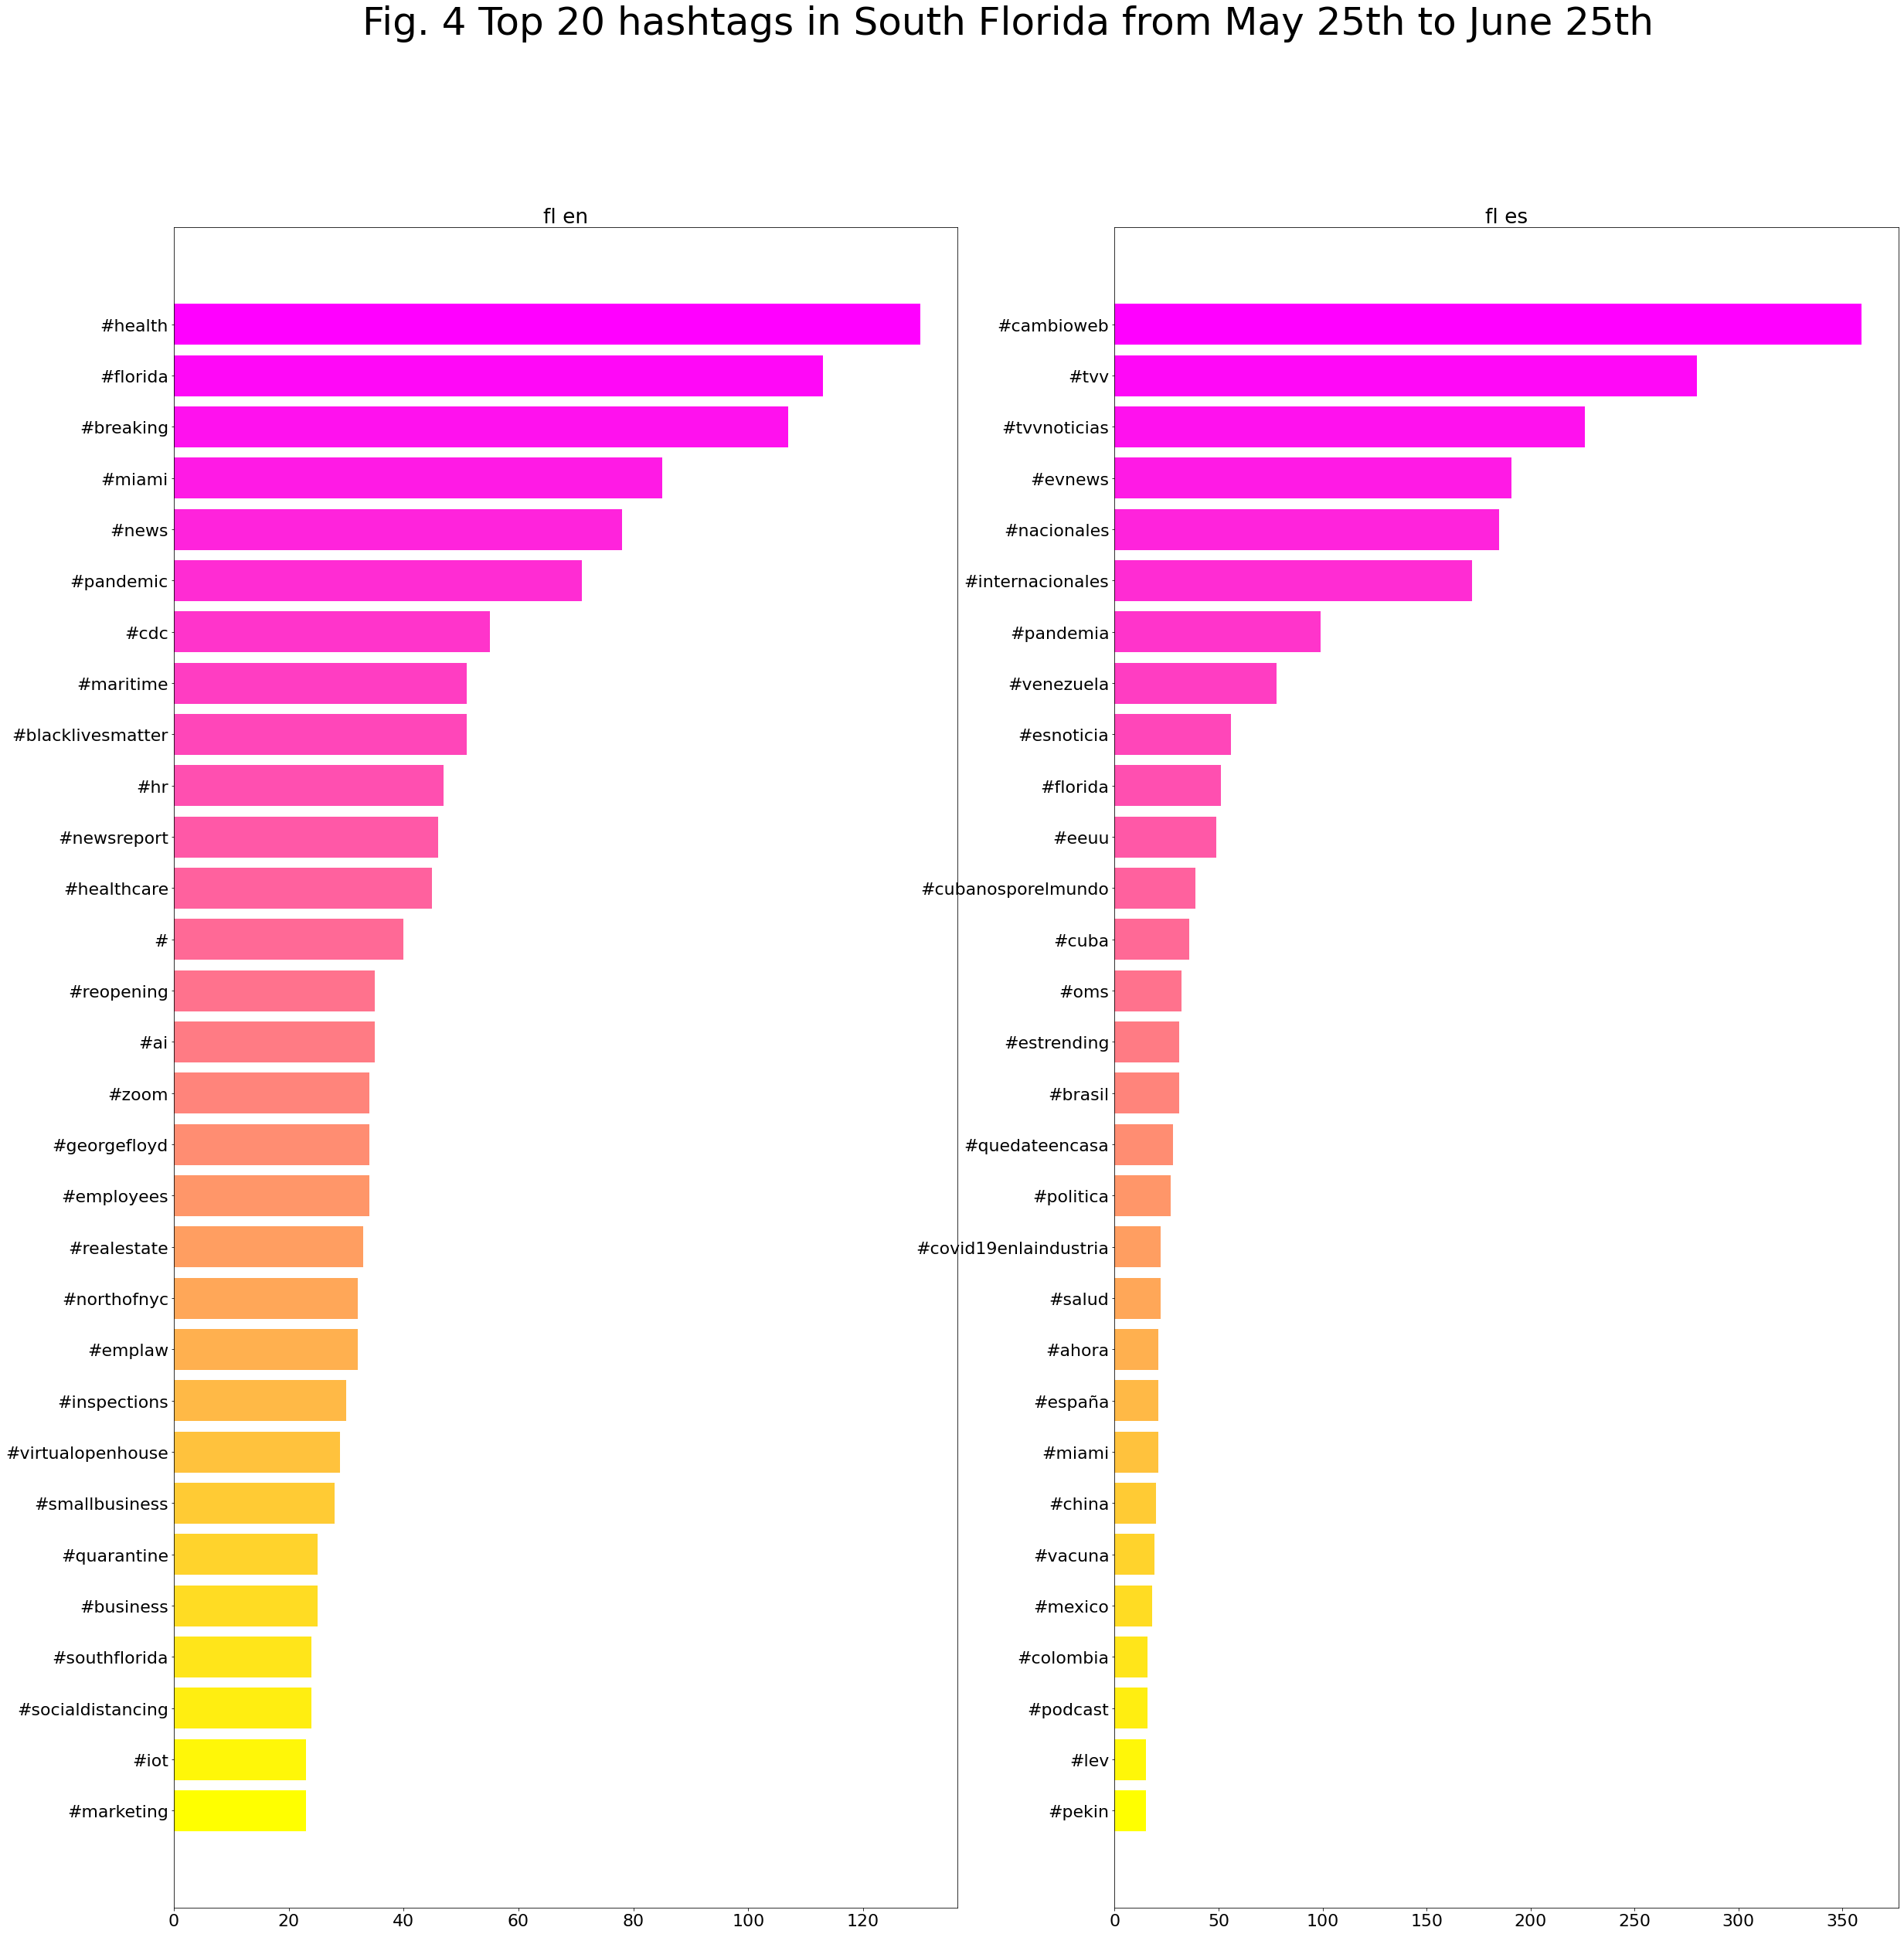

In [220]:
plot_bar_matrix(counts, num_top_words = top_n, num_cols = 2,
               super_title = 'Fig. 4 Top 20 hashtags in South Florida from May 25th to June 25th', super_font = 50)

### Top unique hastags 

In [221]:
col_name = "hashtags"

In [222]:
df = df.dropna(subset=[col_name])

In [223]:
grouping = df.groupby(["geo", "lang"])[col_name]
vocab_dic = uniq_vocab_by_group(grouping)  # unique vocab dictionary 
df[col_name] = df.apply(lambda x : set(x[col_name]) & vocab_dic[(x['geo'], x['lang'])],
                        result_type='reduce', axis=1)  # filtering tweets by that dic

In [224]:
counts = {k: Counter(count_ngrams(t, n_gram, consecutive=False)).most_common(top_n) for k, t in grouping}

In [225]:
pprint(counts)

{('fl', 'en'): [(('#maritime',), 51),
                (('#hr',), 47),
                (('#reopening',), 35),
                (('#ai',), 35),
                (('#zoom',), 34),
                (('#employees',), 34),
                (('#northofnyc',), 32),
                (('#emplaw',), 32),
                (('#inspections',), 30),
                (('#virtualopenhouse',), 29),
                (('#smallbusiness',), 28),
                (('#southflorida',), 24),
                (('#iot',), 23),
                (('#foxnews',), 21),
                (('#ccg',), 21),
                (('#hcahealthcare',), 21),
                (('#wearamask',), 20),
                (('#360wisemedia',), 19),
                (('#shipping',), 19),
                (('#braveofheartfund',), 19),
                (('#travel',), 18),
                (('#b2bsales',), 18),
                (('#innovation',), 18),
                (('#virtuattour',), 18),
                (('#economy',), 17),
                (('#technology',), 

In [226]:
from pylab import rcParams
rcParams['figure.figsize'] = 40, 40  # setting figure size
plt.rcParams.update({'font.size': 22})  # setting font size

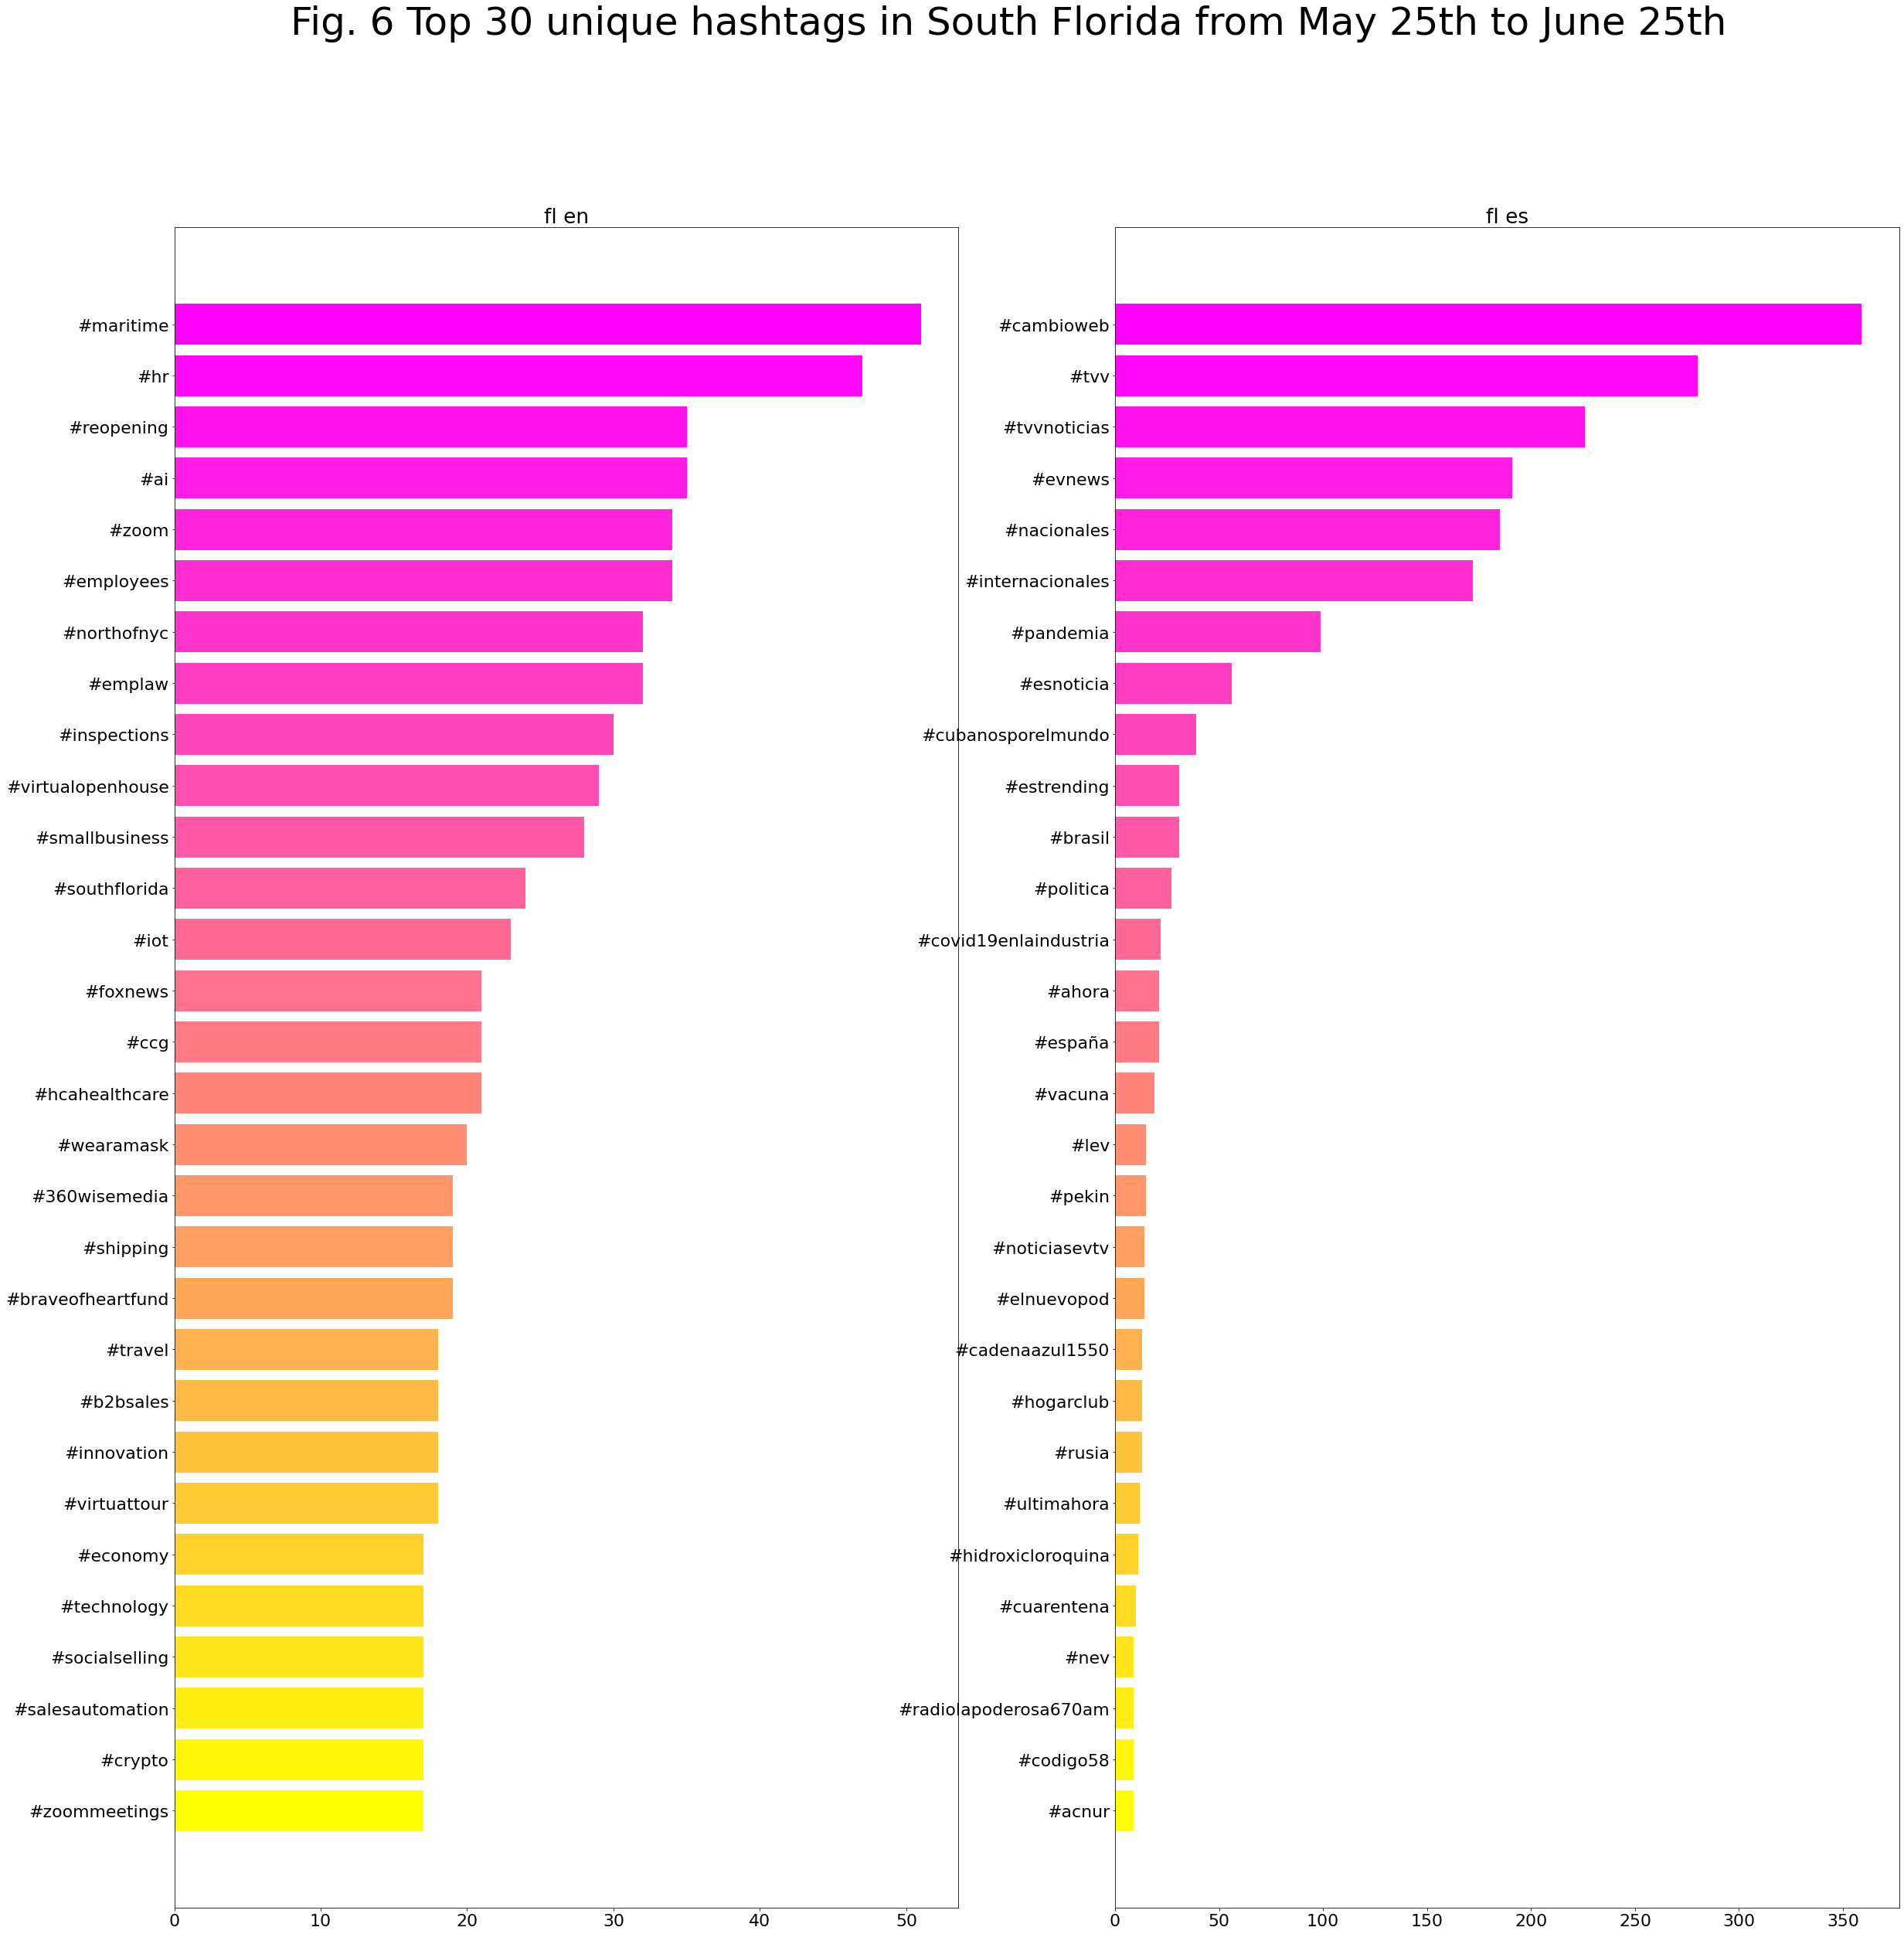

In [227]:
plot_bar_matrix(counts, num_top_words = top_n, num_cols = 2,
               super_title = 'Fig. 6 Top 30 unique hashtags in South Florida from May 25th to June 25th', super_font = 50)